In [1]:
import sys
sys.path.append('../../')

import torch as tc
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from rcgp.rcgp import SpatioTemporalRCGP
from matplotlib.colors import LinearSegmentedColormap

from tqdm import tqdm

from data.simulations import spatio_temporal_half_contaminated

plt.rc('font', family='serif', size=12)

In [52]:
def compute_nlpd(y_true, mu_pred, sigma_pred):

    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    mu_pred = np.array(mu_pred)
    sigma_pred = np.array(sigma_pred)
    
    # Avoid division by zero or invalid log by adding a small epsilon to sigma
    epsilon = 1e-6
    sigma_pred = np.maximum(sigma_pred, epsilon)
    
    # Compute log predictive density for Gaussian
    log_pdf = -0.5 * np.log(2 * np.pi * sigma_pred**2) - ((y_true - mu_pred)**2 / (2 * sigma_pred**2))
    
    # Compute and return the NLPD
    nlpd = -np.mean(log_pdf)
    return nlpd

def compute_rmse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    if len(y_true) != len(y_pred):
        raise ValueError("The lengths of y_true and y_pred must be the same.")
    
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse

In [24]:
ts, grids, Ys, true_Ys, Ys_no_outliers, outliers_loc, n_lon, n_lat, lon_norm, lat_norm = spatio_temporal_half_contaminated()

In [25]:
def scoring_rule(Ys : tc.Tensor, preds : tc.Tensor, covs : tc.Tensor, R : tc.Tensor, Ws: tc.Tensor):

    S = covs + R
    eps = Ys - preds

    mahalanobis_dist = (eps.mT @ tc.linalg.inv(S) @ eps).squeeze()
    norm_const = tc.logdet(2 * tc.pi * S)

    energies = 0.5 * (norm_const + mahalanobis_dist)
    
    return energies.sum()

# Training model on no outliers

100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


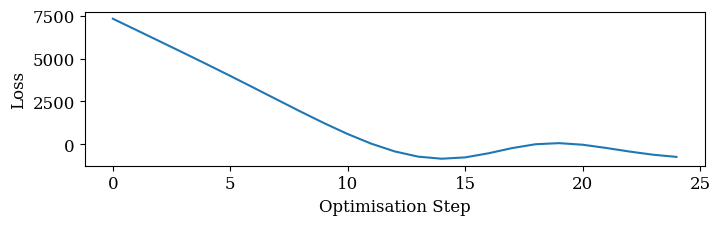

In [26]:
gp_std = SpatioTemporalRCGP(ts=ts, grid=grids[0], Ys=Ys_no_outliers, p=1)
gp_std.deactivate_robustness()

losses = []
n_steps = 25
lr = 0.3

optimizer = tc.optim.Adam(gp_std.parameters(), lr=lr)


for step in tqdm(range(n_steps)):
    _,(preds, covs, R, Ws), _ = gp_std.forward(smoothing=False)

    loss = scoring_rule(Ys=Ys_no_outliers, preds=preds, covs=covs, R=R, Ws=Ws)
    loss.backward()
    losses.append(loss.clone().detach())
    
    optimizer.step()  # Update parameters
    optimizer.zero_grad()  # Reset gradients

plt.figure(figsize=(8,2))
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Optimisation Step");

In [27]:
var_y = gp_std.var_y.clone().detach().item()
temporal_lengthscale = gp_std.temporal_lengthscale.clone().detach().item()
spatial_lengthscale = gp_std.spatial_lengthscale.clone().detach().item()
temporal_magnitude = gp_std.temporal_magnitude.clone().detach().item()
spatial_magnitude = gp_std.spatial_magnitude.clone().detach().item()

print(var_y)
print(temporal_lengthscale, spatial_lengthscale)
print(temporal_magnitude, spatial_magnitude)

0.03425326570868492
0.15441787242889404 6.181653022766113
3.440368890762329 3.4392268657684326


In [39]:
np.quantile(np.abs(Ys - Ys.mean()), 0.9)

2.579543542861939

In [78]:
def get_performance_metrics(model_name, outliers=True, n_iter=10):
    effs = []
    rmses = []
    nlpds = []

    for i in range(n_iter):
        ts, grids, Ys, true_Ys, Ys_no_outliers, outliers_loc, n_lon, n_lat, lon_norm, lat_norm = spatio_temporal_half_contaminated(seed=np.random.randint(1e5))

        if outliers:
            data = Ys
        else:
            data = Ys_no_outliers
        
        model = SpatioTemporalRCGP(ts=ts, grid=grids[0], Ys=data, p=1)
        
        model.var_y = var_y
        model.temporal_lengthscale = temporal_lengthscale
        model.spatial_lengthscale = spatial_lengthscale
        model.temporal_magnitude = temporal_magnitude
        model.spatial_magnitude = spatial_magnitude


        if model_name=='RCGP':
            model.activate_robustness(func='constant')
            model.c = np.quantile(np.abs(data - data.mean()), 0.9)

        elif model_name=='STGP':
            model.deactivate_robustness()

        elif model_name=='ST-RCGP':
            model.activate_robustness(func='m_pred')
            
        with tc.no_grad():
            (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = model.forward(smoothing=True)

        stds_smooth = np.abs(stds_smooth) #this is to avoid [nan] which is not correct to do technically

        rmses.append(compute_rmse(y_true=Ys_no_outliers.squeeze(-1), y_pred=preds_smooth))
        nlpds.append(compute_nlpd(y_true=Ys_no_outliers.squeeze(-1), mu_pred=preds_smooth, sigma_pred=stds_smooth))
        effs.append(eff.mean().item())
        
    return effs, rmses, nlpds

In [79]:
final_list = []

for outliers_bool in [True, False]:
    for model_name in ['RCGP', 'STGP', 'ST-RCGP']:
        effs, rmses, nlpds = get_performance_metrics(model_name=model_name, outliers=outliers_bool, n_iter=50)
        final_list.append([outliers_bool, model_name, np.nanmean(effs), np.nanstd(effs), np.nanmean(rmses), np.nanstd(rmses), np.nanmean(nlpds), np.nanstd(nlpds)])

In [80]:
for i in range(6): print(final_list[i])

[True, 'RCGP', 0.8862466955184937, 0.0007847707290014149, 0.21087605, 0.006321258, 6.5951037, 0.26543644]
[True, 'STGP', 1.0, 0.0, 0.3776762, 0.014853565, 29.950686, 2.4942515]
[True, 'ST-RCGP', 0.8628977191448212, 0.0023695450795896424, 0.19426803, 0.0035213914, 5.459024, 0.1567732]
[False, 'RCGP', 0.8936744379997253, 0.0007098696158299973, 0.19246559, 0.0025235072, 5.5857816, 0.14350414]
[False, 'STGP', 1.0, 0.0, 0.19106537, 0.0016801136, 6.519972, 0.15351626]
[False, 'ST-RCGP', 0.902815591096878, 0.00048587162491969235, 0.19273199, 0.0030335474, 5.6552224, 0.14571653]
